## GO Catalytic Activity Text Definition Analysis

Here we try and do two things

 * If we have a formulaic text definition for an activity in GO, parse it
 * If we have a parsed text definition AND a RHEA xref, compare the two
 
 The reports for this analysis are in https://github.com/cmungall/reactioner/tree/master/reports

In [4]:
## Import libraries and methods
import seaborn as sns
sns.set(style="whitegrid")

import pandas as pd
from notebook_utils import create_venn, create_upset
%matplotlib inline

In [2]:
## Fetch xref data and set up DBs
## File available in GitHub, see https://github.com/cmungall/reactioner/tree/master/reports
df = pd.read_csv("reports/go-rhea-check.tsv", sep="\t").fillna("")
## Show sample
df

,class,class label,def,op,goleft,goright,rhea,rhea label,is_match,info,info label
0,GO:0004133,glycogen debranching enzyme activity,Catalysis of the cleavage of branch points in ...,,,,,,,,
1,GO:0009975,cyclase activity,Catalysis of a ring closure reaction.,,,,,,,,
2,GO:0010280,UDP-L-rhamnose synthase activity,Catalysis of the reaction: UDP-D-glucose + NAD...,,,,,,,,
3,GO:0016491,oxidoreductase activity,Catalysis of an oxidation-reduction (redox) re...,,,,,,,,
4,GO:0016740,transferase activity,"Catalysis of the transfer of a group, e.g. a m...",,,,,,,,
5,GO:0016787,hydrolase activity,"Catalysis of the hydrolysis of various bonds, ...",,,,,,,,
6,GO:0016829,lyase activity,"Catalysis of the cleavage of C-C, C-O, C-N and...",,,,,,,,
7,GO:0016853,isomerase activity,Catalysis of the geometric or structural chang...,,,,,,,,
8,GO:0016874,ligase activity,"Catalysis of the joining of two substances, or...",,,,,,,,
9,GO:0032451,demethylase activity,Catalysis of the removal of a methyl group fro...,,,,,,,,


## Count Plot of matching parsed definition to Rhea reaction

 * blank: text definition could not be parsed OR no Rhea xref
 * `nomatch`: the best parsed text definition CHEBI participants could not be made to match the Rhea one

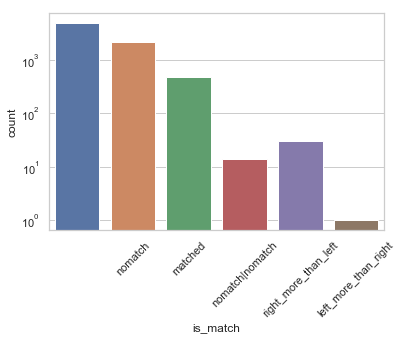

In [8]:
g = sns.countplot(x="is_match", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_yscale('log')